# Post-processing

This notebook contains various plots done after the spin parameter fitting (performed on the cluster with Spark).

In [11]:
import glob
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Results from the fit

In [12]:
class Angle(object):
    def __init__(self, array, unit='deg'):
        self.array = array
        self.unit = unit
        self.deg = self.return_degree()
        self.rad = self.return_radian()
        
    def return_degree(self):
        if self.unit == 'deg':
            return self.array
        elif self.unit == 'rad':
            return np.rad2deg(self.array)
        else:
            print('Unit {} not understood. Choose between `deg` and `rad`.')
            raise ValueError()

    def return_radian(self):
        if self.unit == 'rad':
            return self.array
        elif self.unit == 'deg':
            return np.deg2rad(self.array)
        else:
            print('Unit {} not understood. Choose between `deg` and `rad`.')
            raise ValueError()

class SSO(object):
    def __init__(self, paths, nowrap=False, bftfn='../data/ssoBFT-latest-small.parquet', flavor='gold', verbose=False):
        """
        """
        self.paths = paths
        self.flavor = flavor
        self.verbose = verbose
        self.bftfn = bftfn
        
        self.concat()
        self.filter_nonphysical()
        
        self.merge_with_bft()
        
        self.H = self.pdf['params'].apply(lambda x: x[0]).values
        self.dH = self.pdf['params'].apply(lambda x: x[6]).values
        
        self.G1 = self.pdf['params'].apply(lambda x: x[1]).values
        self.dG1 = self.pdf['params'].apply(lambda x: x[7]).values
        
        self.G2 = self.pdf['params'].apply(lambda x: x[2]).values
        self.dG2 = self.pdf['params'].apply(lambda x: x[8]).values
        
        self.R = self.pdf['params'].apply(lambda x: x[3]).values
        self.dR = self.pdf['params'].apply(lambda x: x[9]).values
        
        self.l = self.pdf['params'].apply(lambda x: x[4]).values
        if not nowrap:
            self.wrap_longitude()
        self.l = Angle(self.l, unit='rad')
        self.dl = Angle(self.pdf['params'].apply(lambda x: x[10]).values, unit='rad')
        
        
        self.b = self.pdf['params'].apply(lambda x: x[5]).values
        if not nowrap:
            self.wrap_latitude()
        self.b = Angle(self.b, unit='rad')
        self.db = Angle(self.pdf['params'].apply(lambda x: x[11]).values, unit='rad')
        
        self.chi2red = self.pdf['params'].apply(lambda x: x[12]).values

    def concat(self):
        tmps = [pd.read_parquet(path) for path in self.paths] 
        self.input_size = len(np.unique(pd.concat(tmps)['ssnamenr']))

        # filter
        for index, tmp in enumerate(tmps):
            mask = self.select_sample(tmp, self.flavor)
            tmp = tmp[mask]

            if self.verbose:
                msg = """
                {}: {}/{}
                """.format(self.paths[index], len(tmp), self.input_size)
                print(msg)

            # inplace replacement
            tmps[index] = tmp

        self.pdf = pd.concat(tmps)
        self.pdf = self.pdf.drop_duplicates(subset=['ssnamenr'])
        self.pdf['ssnamenr'] = self.pdf['ssnamenr'].astype(str)
        
        self.selected_size = len(self.pdf)

    @staticmethod
    def select_sample(tmp, flavor='gold'):
        if flavor == 'gold':
            mask = tmp['params'].apply(lambda x: x[0] == x[0])
            mask *= tmp['params'].apply(lambda x: (x[-1] < 1.5) * (x[-1] > 0.5))
            mask *= tmp['params'].apply(lambda x: x[4]/x[10] >= 3)
            mask *= tmp['params'].apply(lambda x: np.abs(x[5]/x[11]) >= 3)
        elif flavor == 'silver':
            mask = tmp['params'].apply(lambda x: x[0] == x[0])
            mask *= tmp['params'].apply(lambda x: x[-1] < 20)
            mask *= tmp['params'].apply(lambda x: x[4]/x[10] >= 1)
            mask *= tmp['params'].apply(lambda x: np.abs(x[5]/x[11]) >= 1)
        elif flavor == 'bronze':
            mask = tmp['params'].apply(lambda x: x[0] == x[0])
        return mask
    
    def filter_nonphysical(self):
        # correct for bad HG1G2 fit
        mask = self.pdf['params'].apply(lambda x: x[1] + x[2] <= 1)
        self.pdf = self.pdf[mask]
        self.output_size = len(self.pdf)
        
    def wrap_longitude(self):
        mask = self.l > np.pi
        self.l[mask] = self.l[mask] - np.pi
        
    def wrap_latitude(self):
        mask = self.b < 0
        self.b[mask] = -self.b[mask]
        
    def merge_with_bft(self):
        pdf_bft = pd.read_parquet(self.bftfn)
        
        pdf_bft = pdf_bft.rename(columns={'sso_number': 'ssnamenr'})
        
        mask = pdf_bft['ssnamenr'].apply(lambda x: x == x)
        pdf_bft = pdf_bft[mask]
        
        pdf_bft['ssnamenr'] = pdf_bft['ssnamenr'].apply(lambda x: str(int(x)))
        
        self.pdf = pd.merge(self.pdf, pdf_bft, on='ssnamenr')
        

In [35]:
# !mkdir ../nosymmetries
!scp julien.peloton@134.158.75.222:~/fink-broker/ipynb/*nosym*.parquet ../nosymmetries

sso_params_above120_nosymetries.parquet       100%  125KB  10.1MB/s   00:00    
sso_params_above150_nosymetries.parquet       100%  384KB  10.8MB/s   00:00    


In [36]:
paths = glob.glob('../nosymmetries/sso_params_above*.parquet')
nowrap = True
data = SSO(paths, flavor='bronze', nowrap=nowrap)
data.input_size, data.selected_size, data.output_size

# for flavor in ['bronze', 'silver', 'gold']:
#     data = SSO(paths, flavor=flavor)
#     print(data.output_size)

(10939, 4180, 3464)

## Sample

### Data quality

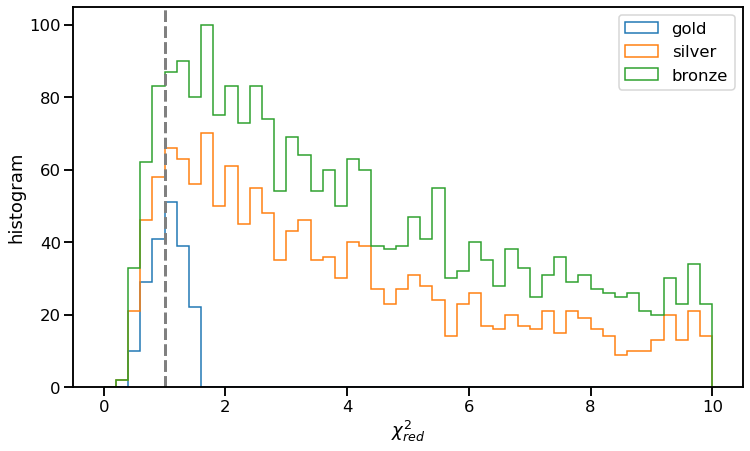

In [37]:
fig = plt.figure(figsize=(12, 7))

for flavor in ['gold', 'silver', 'bronze']:
    data = SSO(paths, flavor=flavor, nowrap=nowrap)

    plt.hist(data.chi2red, bins=50, histtype='step', density=False, range=[0,10], label=flavor)
    plt.axvline(1, ls='--', color='grey', lw=3)
    plt.xlabel(r'$\chi^2_{red}$')
    plt.ylabel('histogram')
    plt.legend()
#     plt.savefig('../plots/papers/chi2red.png', dpi=150)
plt.show()

### Localisation

Text(0, 0.5, '$\\sin$i')

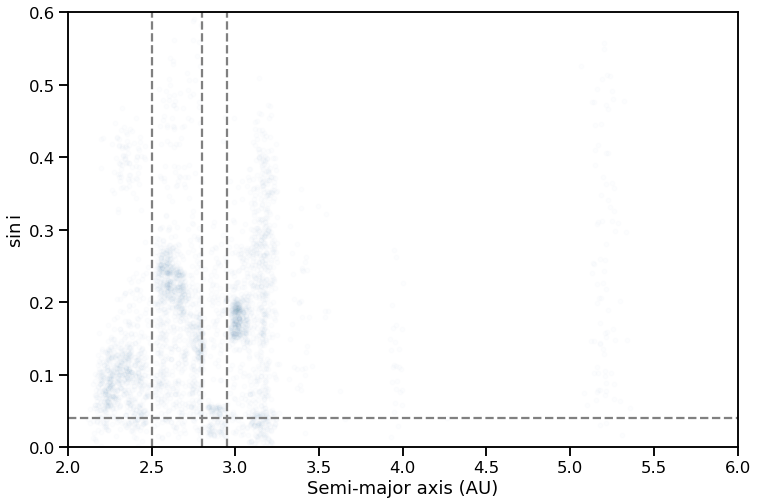

In [38]:
data = SSO(paths, flavor='bronze', nowrap=nowrap)

Is = data.pdf['orbital_elements.inclination.value']
As = data.pdf['orbital_elements.semi_major_axis.value']
Es = data.pdf['orbital_elements.eccentricity.value']

fig = plt.figure(figsize=(12, 8))

plt.scatter(As, np.sin(np.deg2rad(Is)), marker='.', alpha=0.01);
plt.axhline(0.04, ls='--', color='grey')
plt.axvline(2.5, ls='--', color='grey')
plt.axvline(2.8, ls='--', color='grey')
plt.axvline(2.95, ls='--', color='grey')
plt.xlim(2, 6)
plt.ylim(0, 0.6)
# plt.colorbar()
plt.xlabel('Semi-major axis (AU)')
plt.ylabel(r'$\sin$i')
# plt.savefig('../plots/papers/sso.png', dpi=150)

## Distribution of spins

### Longitude

Number of observations for gold: 192/10939
Number of observations for silver: 1860/10939
Number of observations for bronze: 3464/10939


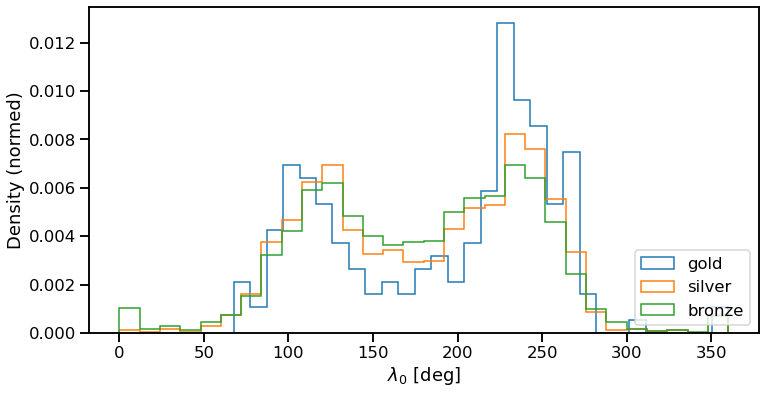

In [39]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:
    data = SSO(paths, flavor=flavor, nowrap=nowrap)
    print('Number of observations for {}: {}/{}'.format(flavor, data.output_size, data.input_size))
    plt.hist(
        data.l.deg, 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=True
    )
    
# plt.yscale('log')
plt.legend(loc='lower right')
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('Density (normed)')
# plt.xlim(0, 180)
# plt.savefig('../plots/papers/l0_density.png', dpi=150)
plt.show()

Number of observations for bronze: 3464/10939


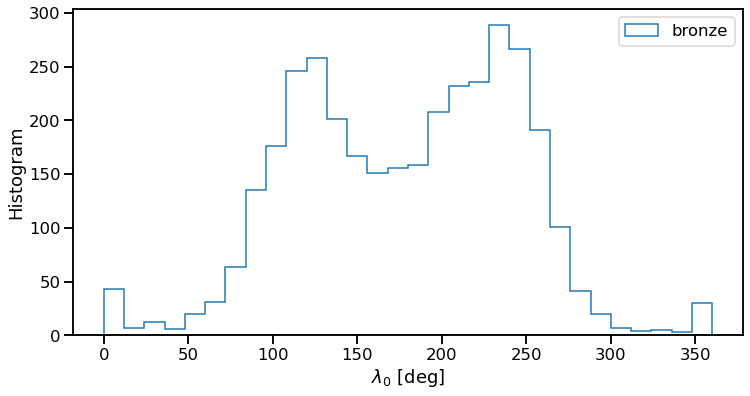

In [40]:
fig = plt.figure(figsize=(12, 6))
data = SSO(paths, flavor='bronze', nowrap=nowrap)
print('Number of observations for {}: {}/{}'.format(flavor, data.output_size, data.input_size))
plt.hist(
    data.l.deg, 
    bins=30,
    histtype='step', 
    label='bronze', 
    density=False
)
    
# plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('Histogram')
# plt.xlim(0, 180)
# plt.savefig('../plots/papers/l0.png', dpi=150)
plt.show()

Text(0, 0.5, 'density (normed)')

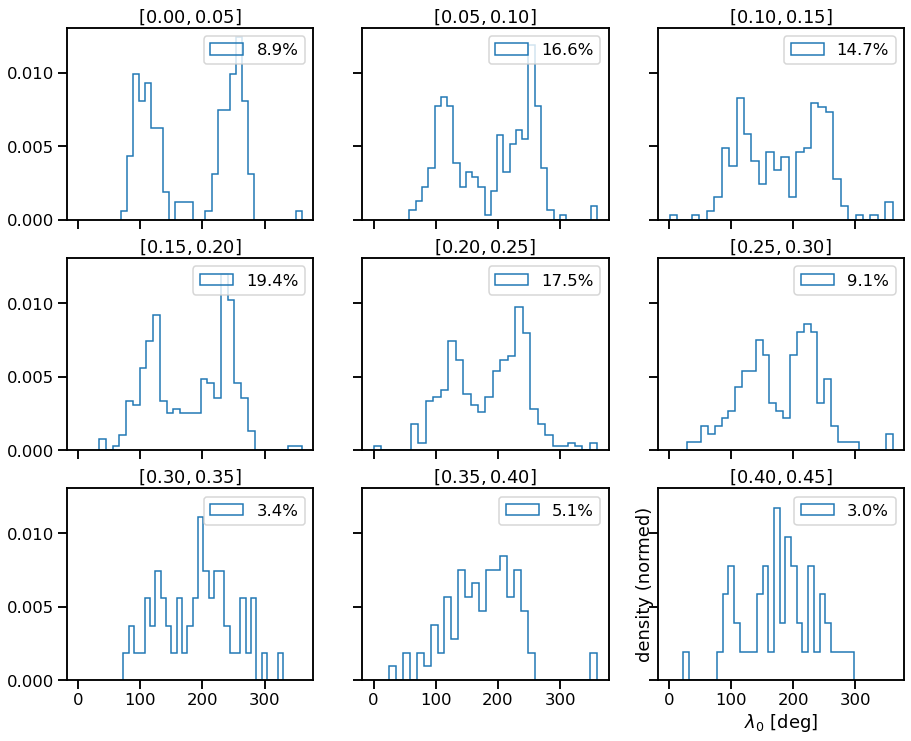

In [41]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

data = SSO(paths, flavor='silver', nowrap=nowrap)
Is = np.sin(np.deg2rad(data.pdf['orbital_elements.inclination.value']))

step = 0.05
shift = 0
for j in range(3):
    for k in range(3):
        for i in range(1):
            low = i*step + shift
            high = (i+1)*step + shift
            m = (Is >= low) * (Is < high)
            axes[j, k].hist(
                data.l.deg[m], 
                bins=30, 
                histtype='step', 
                density=True,
                label='{:.1f}%'.format(len(data.l.deg[m])/data.output_size*100)
            )
            axes[j, k].set_title(r'$[{:.2f}, {:.2f}]$'.format(low, high))
        shift += 0.05
    
#         axes[j, k].set_xlim(0, 180)
        axes[j, k].legend(ncol=1, loc='best')
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('density (normed)')
# plt.savefig('../plots/papers/l0_sini.png', dpi=150)

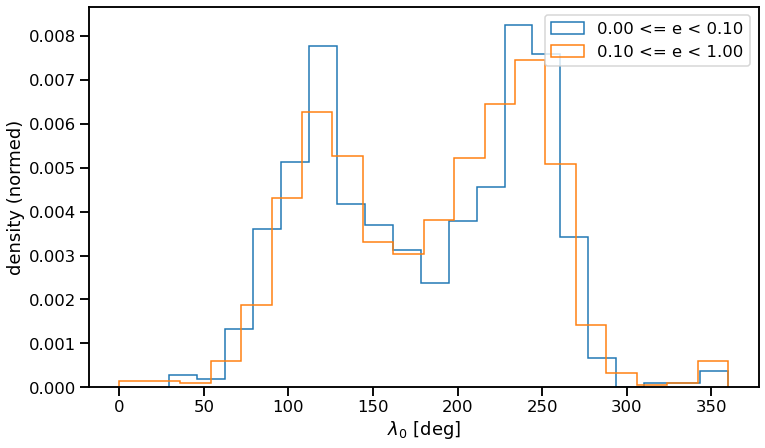

In [42]:
data = SSO(paths, flavor='silver', nowrap=nowrap)
Es = data.pdf['orbital_elements.eccentricity.value']

fig = plt.figure(figsize=(12, 7))

bounds = [[0, 0.1], [0.1, 1]]
for bound in bounds:

    m = (Es >= bound[0]) * (Es < bound[1])
    plt.hist(
        data.l.deg[m], 
        bins=20, 
        density=True,
        histtype='step', 
        label=r'{:.2f} <= e < {:.2f}'.format(bound[0], bound[1])
    )
    
plt.legend()
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('density (normed)')
# plt.savefig('../plots/papers/l0_e.png', dpi=150)
plt.show()

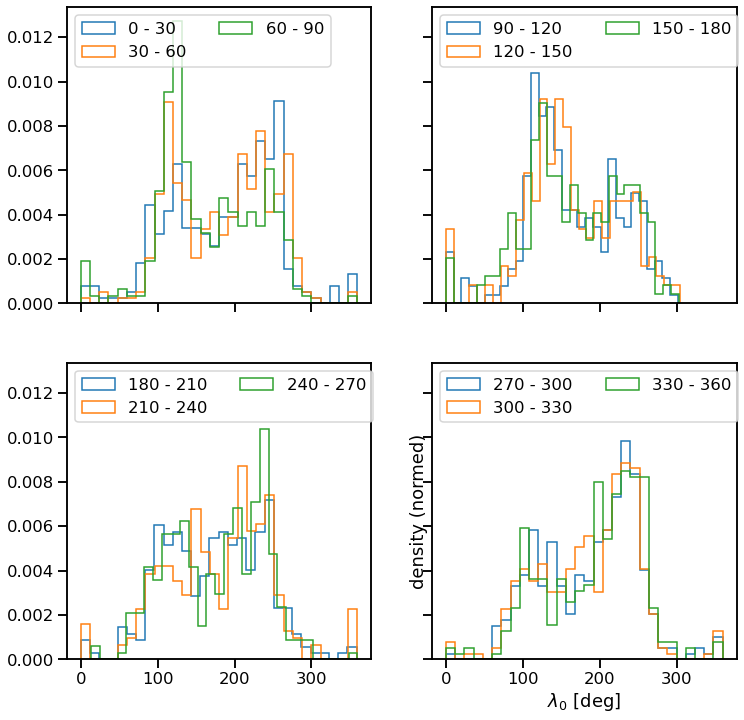

In [43]:
data = SSO(paths, flavor='bronze', nowrap=nowrap)
Ns = data.pdf['orbital_elements.node_longitude.value']

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

step = 30
shift = 0
for j in range(2):
    for k in range(2):
        for i in range(3):
            low = i*step + shift
            high = (i+1)*step + shift
            m = (Ns >= low) * (Ns < high)
            axes[j, k].hist(
                data.l.deg[m], 
                bins=30, 
                histtype='step', 
                density=True,
                label=r'{} - {}'.format(low, high)
            )
        shift += 90
    
#         axes[j, k].set_yscale('log')
        axes[j, k].legend(ncol=2, loc='upper left')
plt.xlabel(r'$\lambda_0$ [deg]')
plt.ylabel('density (normed)')
# plt.xlim(0, 180)
# plt.savefig('../plots/papers/l0_omega.png', dpi=150)
plt.show()

### Latitude

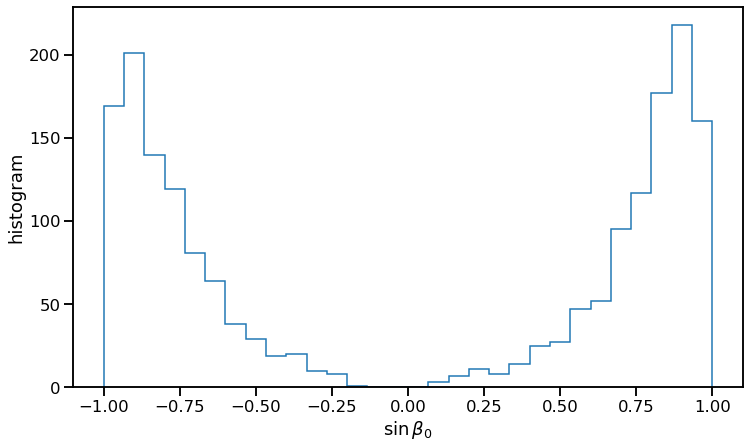

In [44]:
fig = plt.figure(figsize=(12, 7))

data = SSO(paths, flavor='silver', nowrap=nowrap)

plt.hist(np.sin(data.b.rad), bins=30, histtype='step', density=False)
plt.xlabel(r'$\sin \beta_0$')
plt.ylabel('histogram')
# plt.xlim(0, 1)
# plt.savefig('../plots/papers/b0.png', dpi=150)
plt.show()

Number of observations for gold: 192/10939
Number of observations for silver: 1860/10939
Number of observations for bronze: 3464/10939


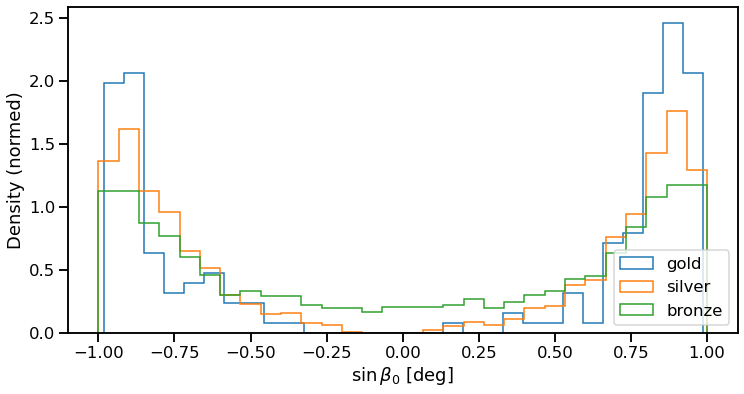

In [45]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:
    data = SSO(paths, flavor=flavor, nowrap=nowrap)
    print('Number of observations for {}: {}/{}'.format(flavor, data.output_size, data.input_size))
    plt.hist(
        np.sin(data.b.rad), 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=True
    )
    
# plt.yscale('log')
plt.legend(loc='lower right')
plt.xlabel(r'$\sin \beta_0$ [deg]')
plt.ylabel('Density (normed)')
# plt.xlim(0, 1)
# plt.savefig('../plots/papers/b0_density.png', dpi=150)
plt.show()

### Oblateness

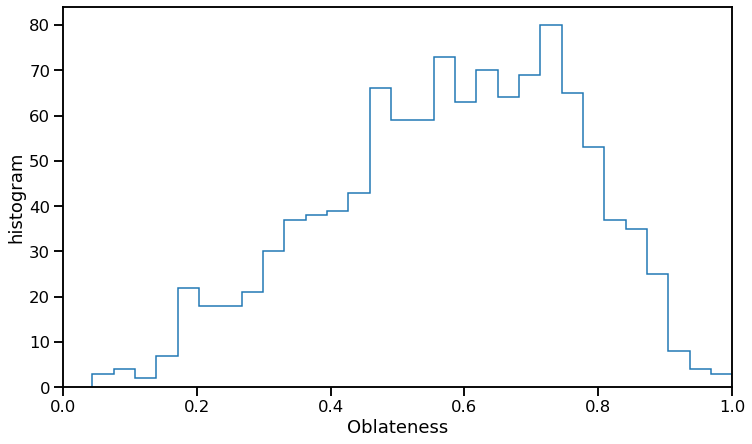

In [46]:
fig = plt.figure(figsize=(12, 7))

data = SSO(paths, flavor='silver', nowrap=nowrap)

plt.hist(data.R[data.R/data.dR > 1], bins=30, histtype='step', density=False)
plt.xlabel(r'Oblateness')
plt.ylabel('histogram')
plt.xlim(0, 1)
# plt.savefig('../plots/papers/oblateness_silver.png', dpi=150)
plt.show()

Number of observations for gold: 60/10939
0.5692395865917206
Number of observations for silver: 535/10939
0.676510751247406
Number of observations for bronze: 1211/10939
0.7372056841850281


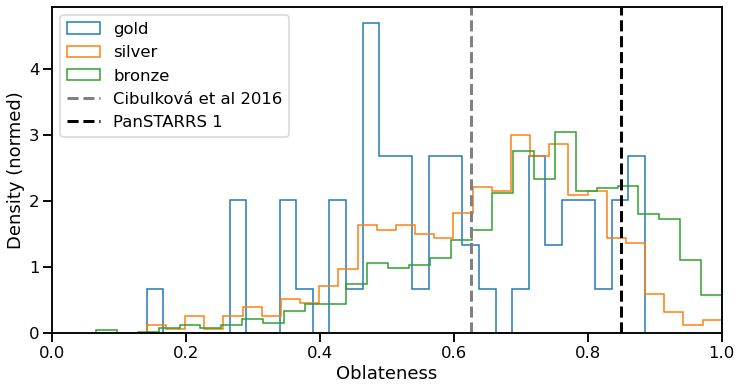

In [47]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:
    data = SSO(paths, flavor=flavor, nowrap=nowrap)
    m = data.R/data.dR > 3
    
    print('Number of observations for {}: {}/{}'.format(flavor, len(data.R[m]), data.input_size))
    
    n, bins, _ = plt.hist(
        data.R[m], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=True
    )
    print(np.median(data.R[m]))
    
# plt.yscale('log')
plt.axvline(1/1.6, ls='--', lw=3, color='grey', label='Cibulková et al 2016')
plt.axvline(0.85, ls='--', lw=3, color='black', label='PanSTARRS 1')
plt.legend(loc='upper left')
plt.xlabel(r'Oblateness')
plt.ylabel('Density (normed)')
plt.xlim(0, 1)
# plt.savefig('../plots/papers/oblateness_density.png', dpi=150)
plt.show()

Number of observations for gold: 60/10939
1.7567355565143126
Number of observations for silver: 535/10939
1.4781731083447203
Number of observations for bronze: 1211/10939
1.3564735343915422


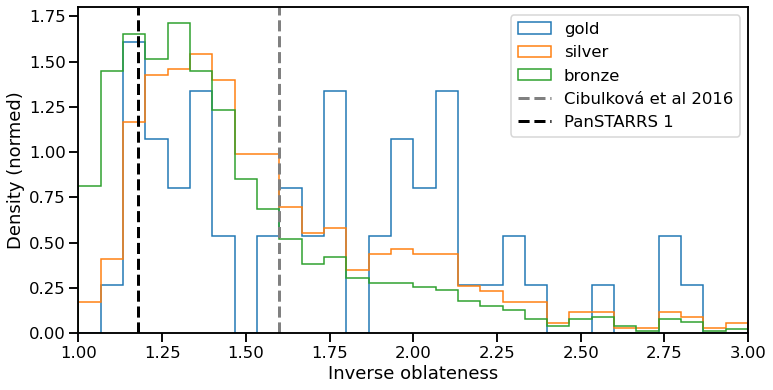

In [48]:
fig = plt.figure(figsize=(12, 6))
for flavor in ['gold', 'silver', 'bronze']:
    data = SSO(paths, flavor=flavor, nowrap=nowrap)
    m = data.R/data.dR > 3
    
    print('Number of observations for {}: {}/{}'.format(flavor, len(data.R[m]), data.input_size))
    
    plt.hist(
        1./data.R[m], 
        bins=30,
        histtype='step', 
        label=flavor, 
        density=True,
        range=[1, 3]
    )
    print(np.median(1/data.R[m]))
    
# plt.yscale('log')
plt.axvline(1.6, ls='--', lw=3, color='grey', label='Cibulková et al 2016')
plt.axvline(1./0.85, ls='--', lw=3, color='black', label='PanSTARRS 1')
plt.legend(loc='upper right')
plt.xlabel(r'Inverse oblateness')
plt.ylabel('Density (normed)')
plt.xlim(1, 3)
# plt.savefig('../plots/papers/inv_oblateness_density.png', dpi=150)
plt.show()

Number of observations for bronze: 107/10939
Number of observations for bronze: 191/10939
Number of observations for bronze: 67/10939
Number of observations for bronze: 63/10939


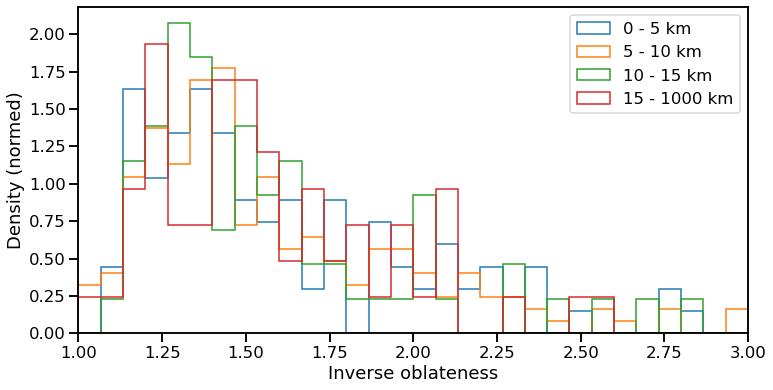

In [49]:
fig = plt.figure(figsize=(12, 6))

data = SSO(paths, flavor='silver')
m = data.R/data.dR > 3

for bounds in [[0, 5], [5, 10], [10, 15], [15, 1000]]:
    m1 = m * (data.pdf['diameter.value'] >= bounds[0]) * (data.pdf['diameter.value'] < bounds[1])
    
    print('Number of observations for {}: {}/{}'.format(flavor, len(data.R[m1]), data.input_size))
    
    plt.hist(
        1./data.R[m1], 
        bins=30,
        histtype='step', 
        label='{} - {} km'.format(*bounds), 
        density=True,
        range=[1, 3]
    )
    
plt.legend(loc='upper right')
plt.xlabel(r'Inverse oblateness')
plt.ylabel('Density (normed)')
plt.xlim(1, 3)
# plt.savefig('../plots/papers/inv_oblateness_diameter.png', dpi=150)
plt.show()

Number of observations for bronze: 113/10939
Number of observations for bronze: 373/10939
Number of observations for bronze: 390/10939
Number of observations for bronze: 141/10939


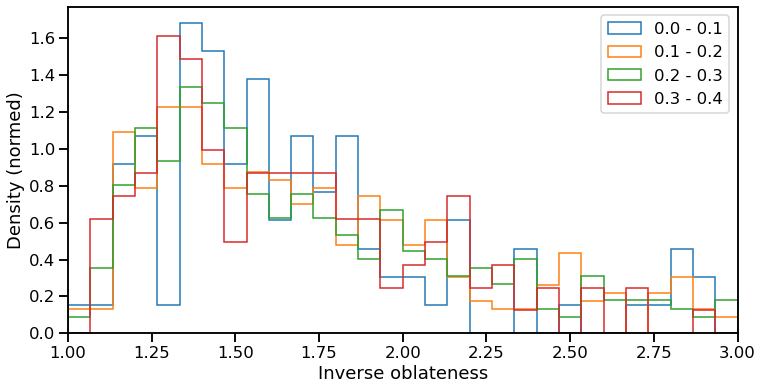

In [50]:
fig = plt.figure(figsize=(12, 6))

data = SSO(paths, flavor='silver')
m = data.R/data.dR > 1

for bounds in [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4]]:
    Is = np.sin(np.deg2rad(data.pdf['orbital_elements.inclination.value']))
    m1 = m * (Is >= bounds[0]) * (Is < bounds[1])
    
    print('Number of observations for {}: {}/{}'.format(flavor, len(data.R[m1]), data.input_size))
    
    plt.hist(
        1./data.R[m1], 
        bins=30,
        histtype='step', 
        label='{} - {}'.format(*bounds), 
        density=True,
        range=[1, 3]
    )
    
plt.legend(loc='upper right')
plt.xlabel(r'Inverse oblateness')
plt.ylabel('Density (normed)')
plt.xlim(1, 3)
# plt.savefig('../plots/papers/inv_oblateness_sini.png', dpi=150)
plt.show()

Text(0, 0.5, 'sin(i)')

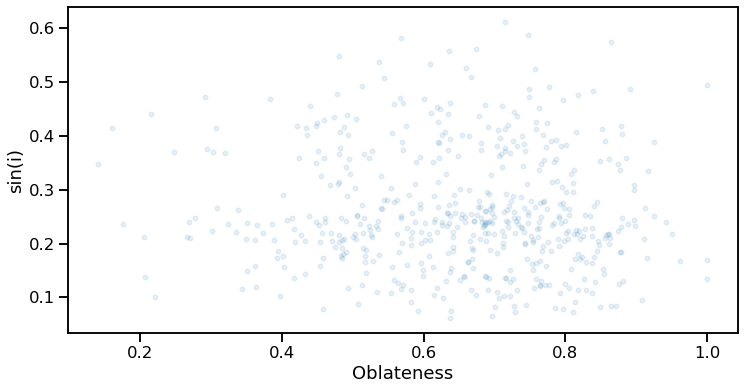

In [51]:
fig = plt.figure(figsize=(12, 6))

data = SSO(paths, flavor='silver')
Is = np.sin(np.deg2rad(data.pdf['orbital_elements.inclination.value']))

m = data.R/data.dR > 3
plt.scatter(data.R[m], Is[m], alpha=0.1, marker='.')
plt.xlabel('Oblateness')
plt.ylabel('sin(i)')

### Abolute magnitude

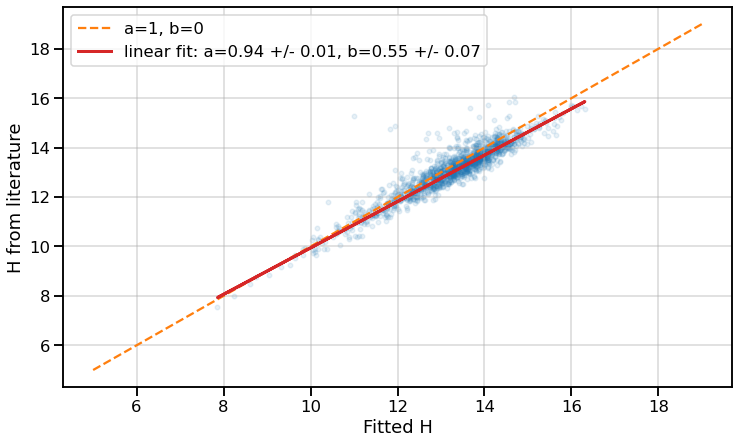

In [52]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

data = SSO(paths, flavor='silver')

# yaxis = data.pdf['phase_functions.Misc/Atlas.orange.H.value'].values
yaxis = data.pdf['phase_functions.Generic/Johnson.V.H.value'].values
mask = yaxis == yaxis
xaxis = data.H[mask]
yaxis = yaxis[mask]

err = data.dH[mask]
m = xaxis/err > 1

yaxis = yaxis[m]
xaxis = xaxis[m]

popt, pcov = curve_fit(linear, xaxis, yaxis, sigma=err[m])
perr = np.sqrt(np.diagonal(pcov))
fig = plt.figure(figsize=(12, 7))
plt.scatter(
    xaxis,
    yaxis,
    marker='.',
    alpha=0.1
)
plt.plot(
    range(5, 20), 
    range(5, 20), 
    color='C1', ls='--', label='a=1, b=0'
)
plt.plot(
    xaxis, 
    linear(xaxis, *popt), 
    label='linear fit: a={:.2f} +/- {:.2f}, b={:.2f} +/- {:.2f}'.format(popt[0], perr[0], popt[1], perr[1]),
    color='C3',
    lw=3
)
plt.xlabel('Fitted H')
plt.ylabel('H from literature')
plt.legend()
plt.grid(alpha=0.5)
# plt.savefig('../plots/papers/H.png', dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


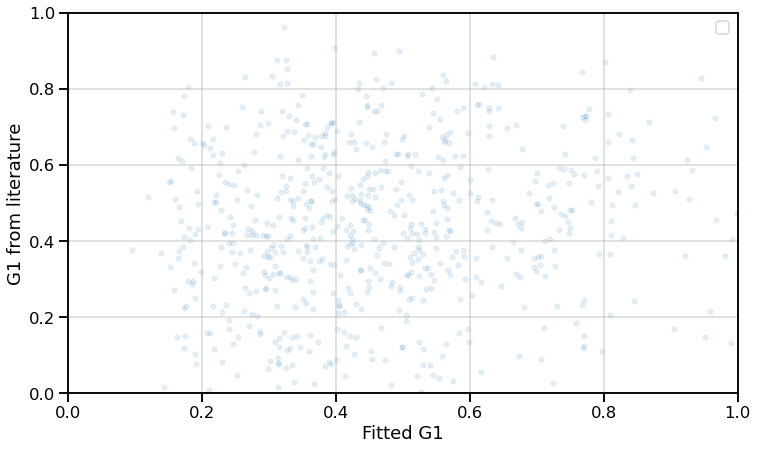

In [53]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

data = SSO(paths, flavor='silver')

# yaxis = data.pdf['phase_functions.Misc/Atlas.orange.G1.value'].values
yaxis = data.pdf['phase_functions.Generic/Johnson.V.G1.value'].values
mask = yaxis == yaxis
xaxis = data.G1[mask]
yaxis = yaxis[mask]

err = data.dG1[mask]
m = xaxis/err > 1

yaxis = yaxis[m]
xaxis = xaxis[m]

popt, pcov = curve_fit(linear, xaxis, yaxis, sigma=err[m])
perr = np.sqrt(np.diagonal(pcov))
fig = plt.figure(figsize=(12, 7))
plt.scatter(
    xaxis,
    yaxis,
    marker='.',
    alpha=0.1
)
# plt.plot(
#     np.arange(0, 1, 0.1), 
#     np.arange(0, 1, 0.1), 
#     color='C1', ls='--', label='a=1, b=0'
# )
# plt.plot(
#     xaxis, 
#     linear(xaxis, *popt), 
#     label='linear fit: a={:.2f} +/- {:.2f}, b={:.2f} +/- {:.2f}'.format(popt[0], perr[0], popt[1], perr[1]),
#     color='C3',
#     lw=3
# )
plt.xlabel('Fitted G1')
plt.ylabel('G1 from literature')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
# plt.savefig('../plots/papers/G1.png', dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


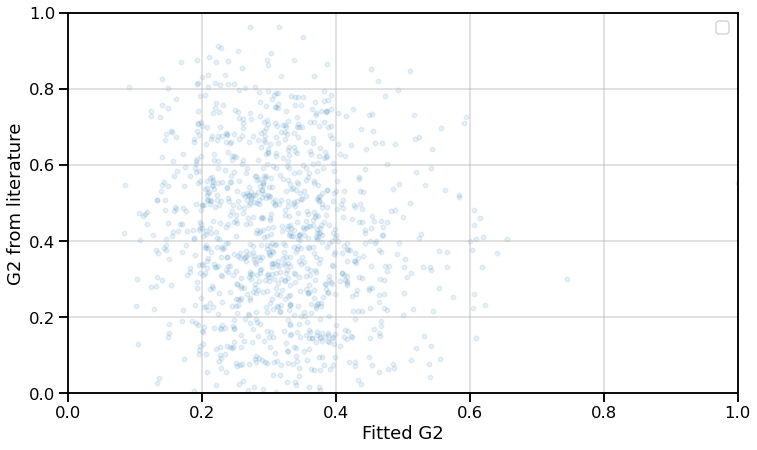

In [54]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

data = SSO(paths, flavor='silver')

# yaxis = data.pdf['phase_functions.Misc/Atlas.orange.G2.value'].values
yaxis = data.pdf['phase_functions.Generic/Johnson.V.G1.value'].values
mask = yaxis == yaxis
xaxis = data.G2[mask]
yaxis = yaxis[mask]

err = data.dG2[mask]
m = xaxis/err > 1

yaxis = yaxis[m]
xaxis = xaxis[m]

popt, pcov = curve_fit(linear, xaxis, yaxis, sigma=err[m])
perr = np.sqrt(np.diagonal(pcov))
fig = plt.figure(figsize=(12, 7))
plt.scatter(
    xaxis,
    yaxis,
    marker='.',
    alpha=0.1
)
# plt.plot(
#     np.arange(0, 1, 0.1), 
#     np.arange(0, 1, 0.1), 
#     color='C1', ls='--', label='a=1, b=0'
# )
# plt.plot(
#     xaxis, 
#     linear(xaxis, *popt), 
#     label='linear fit: a={:.2f} +/- {:.2f}, b={:.2f} +/- {:.2f}'.format(popt[0], perr[0], popt[1], perr[1]),
#     color='C3',
#     lw=3
# )
plt.xlabel('Fitted G2')
plt.ylabel('G2 from literature')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
# plt.savefig('../plots/papers/G2.png', dpi=150)